In [2]:
import os
import torchaudio
import torch
from torchmetrics import SignalNoiseRatio
import matplotlib.pyplot as plt
from torch.nn import Module, Linear, BCELoss, MSELoss, Conv1d, Conv2d, MaxPool2d, Transformer, LayerNorm, PReLU, Fold, ConvTranspose1d, MultiheadAttention, Dropout
from torch.optim import Adam
import torch.nn.functional as F
from pytorch_model_summary import summary
from tqdm import tqdm
import numpy as np
import random
from torchmetrics import ScaleInvariantSignalNoiseRatio
import pickle
import math

/home/dfedorovsky/anaconda3/envs/beamformer/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
import DataLoader

X,Y,speech,noise,mix = DataLoader.data_loader()

In [4]:
class PositionalEncoding(Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)



In [5]:
# TRANSFORMER MASK NET
NUMBER_OF_SPEAKERS = 2
ENCODED_TIMESTEPS = int(50000/8) # 50000 is len of training data -> 50000/8 = 6250
FOLDS = int((ENCODED_TIMESTEPS/250)*2-1)
FILTERS = 256
D_TF = 1024#1024

class TransformerMaskNet(Module):
    def __init__(self,noise=False):
        super(TransformerMaskNet, self).__init__()
        # ENCODER subnet
        self.tdnn = Conv1d(in_channels=1,out_channels=256,kernel_size=16,stride=8,padding=6)

        self.lnorm = LayerNorm(normalized_shape=(256,ENCODED_TIMESTEPS))
        self.lin0 = Linear(in_features=256, out_features=256)

        self.pe = PositionalEncoding(d_model=256)
        self.pe2 = PositionalEncoding(d_model=250)
        self.ln11 = LayerNorm(normalized_shape=(250,FOLDS,256))
        self.ln12 = LayerNorm(normalized_shape=(250,FOLDS,256))
        self.ln21 = LayerNorm(normalized_shape=(250,FOLDS,256))
        self.ln22 = LayerNorm(normalized_shape=(250,FOLDS,256))
        self.ln31 = LayerNorm(normalized_shape=(250,FOLDS,256))
        self.ln32 = LayerNorm(normalized_shape=(250,FOLDS,256))
        self.ln41 = LayerNorm(normalized_shape=(250,FOLDS,256))
        self.ln42 = LayerNorm(normalized_shape=(250,FOLDS,256))
        self.ln51 = LayerNorm(normalized_shape=(256,FOLDS,250))
        self.ln52 = LayerNorm(normalized_shape=(256,FOLDS,250))
        self.ln61 = LayerNorm(normalized_shape=(256,FOLDS,250))
        self.ln62 = LayerNorm(normalized_shape=(256,FOLDS,250))
        self.ln71 = LayerNorm(normalized_shape=(256,FOLDS,250))
        self.ln72 = LayerNorm(normalized_shape=(256,FOLDS,250))
        self.ln81 = LayerNorm(normalized_shape=(256,FOLDS,250))
        self.ln82 = LayerNorm(normalized_shape=(256,FOLDS,250))

        self.mha1 = MultiheadAttention(embed_dim=256,num_heads=8,dropout=0.1)
        self.mha2 = MultiheadAttention(embed_dim=256,num_heads=8,dropout=0.1)
        self.mha3 = MultiheadAttention(embed_dim=256,num_heads=8,dropout=0.1)
        self.mha4 = MultiheadAttention(embed_dim=256,num_heads=8,dropout=0.1)
        self.mha5 = MultiheadAttention(embed_dim=250,num_heads=10,dropout=0.1)
        self.mha6 = MultiheadAttention(embed_dim=250,num_heads=10,dropout=0.1)
        self.mha7 = MultiheadAttention(embed_dim=250,num_heads=10,dropout=0.1)
        self.mha8 = MultiheadAttention(embed_dim=250,num_heads=10,dropout=0.1)

        self.lintf1 = Linear(in_features=256,out_features=D_TF)#1024 instead of 256!
        self.lintf2 = Linear(in_features=256,out_features=D_TF)
        self.lintf3 = Linear(in_features=256,out_features=D_TF)
        self.lintf4 = Linear(in_features=256,out_features=D_TF)
        self.lintf5 = Linear(in_features=250,out_features=D_TF)
        self.lintf6 = Linear(in_features=250,out_features=D_TF)
        self.lintf7 = Linear(in_features=250,out_features=D_TF)
        self.lintf8 = Linear(in_features=250,out_features=D_TF)
        self.lintf12 = Linear(in_features=D_TF,out_features=256)
        self.lintf22 = Linear(in_features=D_TF,out_features=256)
        self.lintf32 = Linear(in_features=D_TF,out_features=256)
        self.lintf42 = Linear(in_features=D_TF,out_features=256)
        self.lintf52 = Linear(in_features=D_TF,out_features=250)
        self.lintf62 = Linear(in_features=D_TF,out_features=250)
        self.lintf72 = Linear(in_features=D_TF,out_features=250)
        self.lintf82 = Linear(in_features=D_TF,out_features=250)

        self.prelu = PReLU()
        self.lin1 = Linear(in_features=256, out_features=(256*NUMBER_OF_SPEAKERS))

        self.fold = Fold(output_size=(1,ENCODED_TIMESTEPS),kernel_size=(1,250),stride=(1,125))
        self.lin2 = Linear(in_features=NUMBER_OF_SPEAKERS*256, out_features=NUMBER_OF_SPEAKERS*256)
        self.lin3 = Linear(in_features=NUMBER_OF_SPEAKERS*256, out_features=NUMBER_OF_SPEAKERS*256)

        self.convT = ConvTranspose1d(in_channels=256,out_channels=1,kernel_size=16,stride=8, padding=4)

        #self.tf1 = Transformer(d_model = 256, nhead=8, dim_feedforward=1024)
        #self.tf2 = Transformer(d_model = 256, nhead=8, dim_feedforward=1024)
        # SEPFORMER Block
        # y = self.tf1(x,torch.rand(250,FOLDS,256))
        # x = y + x
        # y = self.tf2(x,torch.rand(250,FOLDS,256))
        # x = y + x # Residual connection

    def forward(self,x):
        # TDNN Encoder 1x50000 -> 256x6250
        h = self.tdnn(x)

        # NORMALIZATION and Overlapping
        x = self.lnorm(h)
        x = self.lin0(x.view(-1,256))
        x = x.view(256,-1)
        x = x.unfold(dimension=1, step=125, size=250)# Chunking and 50% Overlap

        x = x.reshape(250,FOLDS,256)

        # Transformer 1
        y = self.pe(x)
        z = self.ln11(y)
        z, _ = self.mha1(z,z,z)
        z_2 = z+y
        z = self.ln12(z_2)
        z = self.lintf1(z)
        z = self.lintf12(z)
        x = z+z_2+x
        # Transformer 2
        y = self.pe(x)
        z = self.ln21(y)
        z, _ = self.mha2(z,z,z)
        z_2 = z+y
        z = self.ln22(z_2)
        z = self.lintf2(z)
        z = self.lintf22(z)
        x = z+z_2+x
        # Transformer 3
        y = self.pe(x)
        z = self.ln31(y)
        z, _ = self.mha3(z,z,z)
        z_2 = z+y
        z = self.ln32(z_2)
        z = self.lintf3(z)
        z = self.lintf32(z)
        x = z+z_2+x
        # Transformer 4
        y = self.pe(x)
        z = self.ln41(y)
        z, _ = self.mha4(z,z,z)
        z_2 = z+y
        z = self.ln42(z_2)
        z = self.lintf4(z)
        z = self.lintf42(z)
        x = z+z_2+x

        # PERMUTATION
        x = x.view(256,FOLDS,250)

        # Transformer 5
        y = self.pe2(x)
        z = self.ln51(y)
        z, _ = self.mha5(z,z,z)
        z_2 = z+y
        z = self.ln52(z_2)
        z = self.lintf5(z)
        z = self.lintf52(z)
        x = z+z_2+x
        # Transformer 6
        y = self.pe2(x)
        z = self.ln61(y)
        z, _ = self.mha6(z,z,z)
        z_2 = z+y
        z = self.ln62(z_2)
        z = self.lintf6(z)
        z = self.lintf62(z)
        x = z+z_2+x
        # Transformer 7
        y = self.pe2(x)
        z = self.ln71(y)
        z, _ = self.mha7(z,z,z)
        z_2 = z+y
        z = self.ln72(z_2)
        z = self.lintf7(z)
        z = self.lintf72(z)
        x = z+z_2+x
        # Transformer 8
        y = self.pe2(x)
        z = self.ln81(y)
        z, _ = self.mha8(z,z,z)
        z_2 = z+y
        z = self.ln82(z_2)
        z = self.lintf8(z)
        z = self.lintf82(z)
        x = z+z_2+x

        # PRELU and Linear
        x = self.prelu(x)
        x = x.view(FOLDS,250,256)
        x = self.lin1(x)
        x = F.relu(x)
        x = x.reshape(256*NUMBER_OF_SPEAKERS,250,FOLDS)

        # OVERLAP ADD (256*#S,250,49) -> (256,#S,6250)
        x = self.fold(x)
        
        # FFN + ReLU (256,#S,6250) -> (#S, 256,6250)
        x = self.lin2(x.view(-1,NUMBER_OF_SPEAKERS*256))
        x = self.lin3(x.view(-1,NUMBER_OF_SPEAKERS*256))
        x = F.relu(x)

        x = x.view(NUMBER_OF_SPEAKERS,256,6250)
        # DECODER
        x = self.convT(x*h)

        return x

    

print(summary(TransformerMaskNet(),torch.zeros((1, ENCODED_TIMESTEPS*8))))

--------------------------------------------------------------------------------------------
            Layer (type)                       Output Shape         Param #     Tr. Param #
                Conv1d-1                        [256, 6250]           4,352           4,352
             LayerNorm-2                        [256, 6250]       3,200,000       3,200,000
                Linear-3                        [6250, 256]          65,792          65,792
    PositionalEncoding-4                     [250, 49, 256]               0               0
             LayerNorm-5                     [250, 49, 256]       6,272,000       6,272,000
    MultiheadAttention-6     [250, 49, 256], [49, 250, 250]         263,168         263,168
             LayerNorm-7                     [250, 49, 256]       6,272,000       6,272,000
                Linear-8                    [250, 49, 1024]         263,168         263,168
                Linear-9                     [250, 49, 256]         262,400    

In [70]:
EPOCHS = 10
BATCH_SIZE = 1
REFERENCE_CHANNEL = 0
INIT_LR = 0.001#0.000015
PICKLE_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/params.pkl'
MODEL_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/TF'

CUDA = True # if torch.cuda.is_available()
device =  torch.device("cuda:2") if torch.cuda.is_available() else torch.device('cpu')
print("Mounted on:", device)

lossBCE = ScaleInvariantSignalNoiseRatio().to(device)

model = TransformerMaskNet().to(device)
model= torch.nn.DataParallel(model,device_ids=[2])
opt = Adam(model.parameters(), lr=INIT_LR)

H = {
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

def check_accuracy_training(speech_pred, y_s):
    speech_pred = (speech_pred>0.15).float()
    return float(torch.sum((speech_pred == y_s).float())/torch.sum(torch.ones(513,speech_pred.shape[1])))

def check_accuracy_validation(model):
    example_nr = int(np.random.random()*(len(speech)-len(trainX))+len(trainX))
    model.eval()
    pred = model(X[example_nr]).reshape(1,513,-1)
    val_loss = lossBCE(pred,Y[example_nr][0].unsqueeze(0))
    pred = (pred>0.15).float()
    model.train()
    return float(torch.sum((pred == Y[example_nr][0]).float())/torch.sum(torch.ones(513,X[example_nr].shape[2])).to(device)),val_loss

print("[INFO] training the network...")

for epoch in range(0, EPOCHS):
    print("Epoch:",str(epoch+1)+"/"+str(EPOCHS))
    # Train Mode
    model.train()
    
    # Initialize
    totalTrainLoss = 0
    totalValLoss = 0
    trainCorrect = 0
    valCorrect = 0

    X = mix.to(device)
    Y = speech.to(device)
    trainX = X[:2000]
    trainY = Y
    for i in tqdm(range(0,len(trainX))): # Iterate over Training Examples
        (x, y) = (trainX[i],trainY[i])
        speech_pred=model(x)
        loss = lossBCE(speech_pred,y)
        # zero out the gradients, perform the backpropagation step, and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        #H["train_acc"].append(check_accuracy_training(speech_pred,y))
        #H["train_acc"].append(check_accuracy_training(speech_pred,y))
        H["train_loss"].append(float(loss))
        #if i % 10 == 0:
            #val_acc, val_loss = check_accuracy_validation(model)
            #H["val_acc"].append(val_acc)
            #H["val_loss"].append(float(val_loss))
        # if i % 100 == 0:
        #     if i == 0:
        #         continue
        #     print("Average Training Accuracy at Iteration",str(i),":",np.mean(np.array(H["train_acc"])))
        #     print("Total Training Loss at Iteration",str(i),":",np.sum(np.array(H["train_loss"])))
        #     print("Average Validation Accuracy at Iteration",str(i),":",np.mean(np.array(H["val_acc"])))
        #     print("Total Validation Loss at Iteration",str(i),":",np.sum(np.array(H["val_loss"])))
    # Save
    torch.save(model.state_dict(), MODEL_SAVE_PATH + "epoch"+ str(epoch+1) + ".pt")

torch.save(model.state_dict(), MODEL_SAVE_PATH + "final" + ".pt")
with open(PICKLE_SAVE_PATH, 'wb') as f:
    pickle.dump(H, f)

Mounted on: cuda:2
[INFO] training the network...
Epoch: 1/10


  2%|▏         | 44/2000 [00:18<13:47,  2.36it/s]


KeyboardInterrupt: 

In [ ]:
PICKLE_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/params.pkl'

with open(PICKLE_SAVE_PATH, 'rb') as f:
    H = pickle.load(f)

n = 10
plt.plot(H["train_loss"][::n*10])
plt.plot(H["val_loss"][::n])
plt.legend(['Training Loss', 'Validation Loss'])

In [6]:
MODEL_SAVE_PATH = '/project/data_asr/CHiME5/data/librenoise/models/TF'

MODEL_NAME = "epoch10.pt"
model = TransformerMaskNet().cpu()
model.load_state_dict(torch.load(MODEL_SAVE_PATH+MODEL_NAME),strict=False)
model.eval()

TransformerMaskNet(
  (tdnn): Conv1d(1, 256, kernel_size=(16,), stride=(8,), padding=(6,))
  (lnorm): LayerNorm((256, 6250), eps=1e-05, elementwise_affine=True)
  (lin0): Linear(in_features=256, out_features=256, bias=True)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (pe2): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (ln11): LayerNorm((250, 49, 256), eps=1e-05, elementwise_affine=True)
  (ln12): LayerNorm((250, 49, 256), eps=1e-05, elementwise_affine=True)
  (ln21): LayerNorm((250, 49, 256), eps=1e-05, elementwise_affine=True)
  (ln22): LayerNorm((250, 49, 256), eps=1e-05, elementwise_affine=True)
  (ln31): LayerNorm((250, 49, 256), eps=1e-05, elementwise_affine=True)
  (ln32): LayerNorm((250, 49, 256), eps=1e-05, elementwise_affine=True)
  (ln41): LayerNorm((250, 49, 256), eps=1e-05, elementwise_affine=True)
  (ln42): LayerNorm((250, 49, 256), eps=1e-05, elementwise_affine=True)
  (ln51): LayerNorm((256, 49, 250), eps=1e-05

torch.Size([1, 50000])


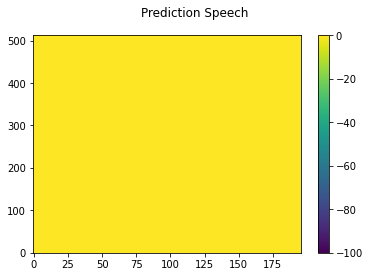

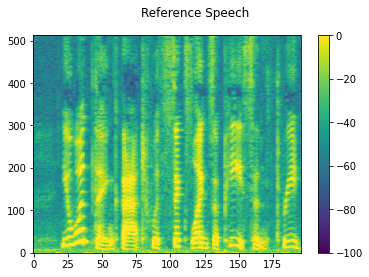

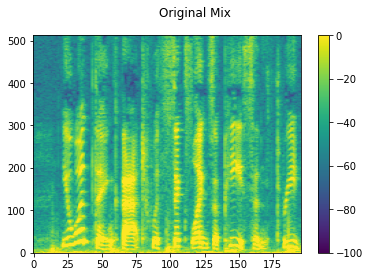

In [19]:
# STFT
N_FFT = 1024
N_HOP = 256

stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)

def plot_spectrogram(sound, title="Spectrogram", xlim=None):
    sound = stft(sound).reshape(513,196)
    magnitude = sound.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).detach().numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-100, vmax=0, origin="lower", aspect="auto")
    figure.suptitle(title)
    plt.colorbar(img, ax=axis)
    plt.show()

def evaluate_example(e_nr):
    model.eval()
    #speech_pred = (model(X[e_nr]).reshape(513,-1)>0.2).float()
    pred = model(mix[e_nr])
    speech_pred=pred
    #speech_pred = model(X[e_nr]).reshape(513,-1)
    print(speech_pred[0].shape)
    plot_spectrogram(speech_pred[0], title="Prediction Speech")
    plot_spectrogram(speech[e_nr], title="Reference Speech")
    plot_spectrogram(mix[e_nr][0], title="Original Mix")

evaluate_example(200)